# Importation des modules

In [40]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Définition des paramètres

### Paramètres géométriques

In [41]:
L_x, L_y = 10, 5 # Longueur et largeur de notre domaine d'étude
N_x, N_y = 100, 50 # Nombre de mailles selon x et selon y

Attention à ne pas confondre **nombre de mailles** et **nombre de points**.

Typiquement, on a choisi de représenter l'intervalle continu $[0, L_x]$ par l'intervalle discret de points $\llbracket 0, N_x \rrbracket$. Ainsi, il y a bien $N_x$ **mailles**, de la forme $[x_i, x_{i+1}]$, mais **Nx + 1 points**.

De même, selon y, il y a $N_y$ **mailles** et donc $N_y+1$ **points**.

In [42]:
dx = L_x/N_x # Taille d'une maille selon x
dy = L_y/N_y # Taille d'une maille selon y

In [43]:
dt = 1 # Choix du pas de temps de notre simulation
N_t = 1000 # Temps maximal de notre simulation

### Paramètres physiques

Posons d'abord les conditions limites de notre problème.

In [44]:
T_0 = 300  # Température initiale du corps étudié, en Kelvin (environ 27°C)
# Il est conseillé de garder 300 K : la densité et la capacité thermique d'un corps 
# sont thermosensibles, et plus loin on les prendra à 300 K.

T_1 = 323.15  # Température imposée au bord y=0, en Kelvin (50°C)
T_a = 273.15  # Température ambiante du fluide en x=Lx, en Kelvin (0°C)

Profitons-en pour donner quelques valeurs courantes pour des corps physiques usuels. 

En vérité, toutes les grandeurs qui peuvent servir à caractériser le comportement thermique d'un matériau ($\lambda$, $\rho$, $c_p$) sont elles-même thermosensibles. Pour se simplifier la vie, on les supposera constantes et égales à leur valeur à 300 K.

*(source : Transferts thermiques - J. Taine, F. Enguehard, E. Iacona - Éditions Dunod)*

In [45]:
class CorpsPhysique:
    def __init__(self, name, lambd, rho, cp):
        self.name = name  # Nom du corps physique
        self.lambd = lambd  # Conductivité thermique en W/(m·K)
        self.rho = rho  # Densité en kg/m³
        self.cp = cp  # Capacité thermique en J/(kg·K)
    
    def alpha(self):
        return self.lambd / (self.rho * self.cp)
    
# ERRATUM : convention du rapport c'est plutôt a pour la diffusivité
# Mieux vaut donc corriger ça et utiliser alpha pour les alpha_n plus loin.

air = CorpsPhysique("air", 0.0263, 1.1614, 1007)  # Air à 300 K
cuivre = CorpsPhysique("cuivre", 399, 8954, 383)  # Cuivre à 300 K

# Pour rajouter de nouveaux corps physiques, c'est ici.


Le calcul exact d'un coefficient de conducto-convection peut être délicat, et faire intervenir des nombres de Prandtl, Nusselt, la dilatation thermique et la gravité... Pour faire simple, nous imposerons un ordre de grandeur de h qu'on admettra comme cohérente pour de la convection naturelle laminaire sur une plaque plane (un mur).

In [46]:
# Si on veut changer le coefficient de convection extérieure, c'est ici.
h = 10 # en W/(m²·K)

# Si on veut changer le corps étudié, c'est ici.
corps = cuivre

In [47]:
lambd, alpha = corps.lambd, corps.alpha()

# Calcul du temps caractéristique de conduction selon x
t_cond_x = L_x**2 / alpha
print(f"Temps caractéristique de conduction selon x: {t_cond_x:.2f}")

# Calcul du temps caractéristique de conduction selon y
t_cond_y = L_y**2 / alpha
print(f"Temps caractéristique de conduction selon y: {t_cond_y:.2f}")

print()

# Calcul du temps caractéristique de convection selon x
t_conv_x = t_cond_x / h
print(f"Temps caractéristique de convection selon x: {t_conv_x:.2f}")

# Calcul du temps caractéristique de convection selon y
t_conv_y = t_cond_y / h
print(f"Temps caractéristique de convection selon y: {t_conv_y:.2f}")

print()

# Calcul du nombre de Biot selon x
Bi_x = h * L_x / lambd
print(f"Nombre de Biot selon x: {Bi_x:.2f}")

# Calcul du nombre de Biot selon y
Bi_y = h * L_y / lambd
print(f"Nombre de Biot selon y: {Bi_y:.2f}")

print()

# Calcul du nombre de Fourier selon x
Fo_x = alpha * dt / dx**2
print(f"Nombre de Fourier selon x: {Fo_x:.5f}")

# Calcul du nombre de Fourier selon y
Fo_y = alpha * dt / dy**2
print(f"Nombre de Fourier selon y: {Fo_y:.5f}")


Temps caractéristique de conduction selon x: 859494.24
Temps caractéristique de conduction selon y: 214873.56

Temps caractéristique de convection selon x: 85949.42
Temps caractéristique de convection selon y: 21487.36

Nombre de Biot selon x: 0.25
Nombre de Biot selon y: 0.13

Nombre de Fourier selon x: 0.01163
Nombre de Fourier selon y: 0.01163


# Résolution numérique

Nous allons implémenter la méthode ADI.

# Résolution analytique

L'énoncé indique que la solution analytique est donnée par la formule suivante :

$\displaystyle T(x,y) = T_a + \frac{2h}{\lambda} (T_1 - T_a) \sum_{n=1}^\infty \frac{\cos(\alpha_n x) \cosh(\alpha_n (L_y - y))}{[(\alpha_n^2 + \beta^2) L_x + \beta] \cos(\alpha_n L_x) \cosh(\alpha_n L_x)}$

où $\alpha_n$ désigne la nième solution positive de l'équation $\alpha \tan(L_x \alpha) = \beta = \displaystyle \frac{h}{\lambda}$.

Commençons donc par rédiger une fonction qui, à $n$ donné, permet d'obtenir $\alpha_n$. C'est une équation non-linéaire, on est contraint d'utiliser un algorithme de résolution numérique.

In [48]:
beta = h / lambd

def f(a):
    # Fonction dont on cherche les zéros - Ici la variable est nommée a
    # et non alpha, pour éviter toute confusion avec la diffusivité thermique 
    return a * np.tan(L_x * a) - beta

C'est une équation non-linéaire, on va devoir utiliser un algorithme de résolution numérique.
Le module ```scipy.optimize``` propose la fonction ```fsolve``` qui est une variante de l'algorithme de Newton-Raphson.
De tels algorithmes ont besoin d'une **estimation initiale** de la solution avant de chercher.
On peut montrer, avec les propriétés de la fonction $\tan$, que : 
- la première racine de l'équation $f(a) = 0$ sera située avant $\frac{\pi}{2L_x}$, et que donc on peut commencer par placer le curseur à $\frac{\pi}{4L_x}$.
- la $n$-ième racine sera proche de $\frac{n \pi}{L_x}$, et que donc ceci en constitue une bonne estimation.

In [49]:
def n_premieres_solutions(n):
    # Liste pour stocker les solutions
    solutions = []

    # Estimation initiale de la solution
    a0 = np.pi / (4 * L_x)
    nb_solutions = 0

    while nb_solutions < n:
        solution = fsolve(f, a0)[0]

        # Si la solution est déjà dans la liste, l'ignorer
        if solution in solutions:
            print("Solution déjà trouvée !")
            a0 += np.pi / L_x
            continue

        # Ajout de la solution à la liste
        solutions.append(solution)

        nb_solutions += 1
        a0 = nb_solutions * np.pi / L_x

    return solutions


On a de quoi obtenir les $n$ premières valeurs de $\alpha_n$. 

Rappelons qu'on cherche à calculer la série :

$\displaystyle T(x,y) = T_a + \frac{2h}{\lambda} (T_1 - T_a) \sum_{n=1}^\infty \frac{\cos(\alpha_n x) \cosh(\alpha_n (L_y - y))}{[(\alpha_n^2 + \beta^2) L_x + \beta] \cos(\alpha_n L_x) \cosh(\alpha_n L_x)}$

Deux approches sont alors possibles pour calculer une somme s'approchant au plus de cette série :
- On se fixe un nombre de termes ```N``` que l'on considère comme suffisamment grand. Par exemple, ```N = 100```.
- On fait l'hypothèse que le terme général n'oscille pas trop et que donc, si l'on trouve une première occurence bornée par une tolérance donnée ```epsilon```, alors on peut s'arrêter là. 

In [50]:
# On peut ici choisir si l'on préfère le mode "jusqu'à N termes" ou "jusqu'à un terme epsilon"
type_boucle = "while" # ou "for"

# Si on veut changer le nombre de termes de la série à calculer, c'est ici.
N = 100

# Si on veut changer la valeur à partir de laquelle on s'arrête de calculer des termes de la série, c'est ici.
epsilon = 1e-5

Cette série est donnée comme convergente, ainsi on sait que son terme général tend vers 0 et que donc, pour tout $\varepsilon > 0$, il existe une valeur $N_\varepsilon$ telle que le terme général devient dominé par $\varepsilon$ à partir du terme $N_\varepsilon$. Quelle que soit l'approche choisie, elle sera donc à peu près correcte, même si on ne réalise pas de preuve mathématique pour borner l'erreur. Procédons :

In [51]:
def serie(x, y, _L_x = L_x, _L_y = L_y, _beta = beta, _N = N, _epsilon = epsilon):
    somme = 0
    if type_boucle == "for":
        liste_alphas = n_premieres_solutions(N)
        for k in range(1, N+1):
            a_k = liste_alphas[k-1]
            terme_k = np.cos(a_k * x) * np.cosh(a_k * (_L_y - y)) / (((a_k**2 + _beta**2) * _L_x + _beta) * np.cos(a_k * _L_x) * np.cosh(a_k * _L_y))
            somme += terme_k
    elif type_boucle == "while":
        k = 1
        while True:
            a_k = n_premieres_solutions(k)[-1]  # on récupère la k-ième solution
            terme_k = np.cos(a_k * x) * np.cosh(a_k * (_L_y - y)) / (((a_k**2 + _beta**2) * _L_x + _beta) * np.cos(a_k * _L_x) * np.cosh(a_k * _L_y))
            if abs(terme_k) < _epsilon:
                break
            somme += terme_k
            k += 1
    else:
        return "Type de boucle non reconnu."
    return somme

def T_analytique(x, y, _h = h, _lambd = lambd, _T_1 = T_1, _T_a = T_a):
    return _T_a + 2 * _h / _lambd * (_T_1 - _T_a) * serie(x, y)

Ainsi, ```T_analytique(x,y)``` renvoie bien le $T(x,y)$ voulu, du moins avec une certaine précision.

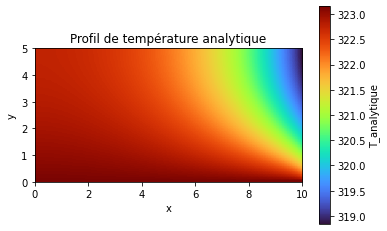

In [52]:
def plot_temperature():
    x_values = np.linspace(0, L_x, N_x)
    y_values = np.linspace(0, L_y, N_y)
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.vectorize(T_analytique)(X, Y)

    plt.figure()
    plt.imshow(Z, cmap='turbo', origin='lower', extent=[0, L_x, 0, L_y])
    plt.colorbar(label='T_analytique')
    plt.title('Profil de température analytique')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot_temperature()